<h1>Table of Contents<span class="tocSkip"></span></h1>
<li><span><a href="#3.-Results" data-toc-modified-id="3.-Results-4"><span class="toc-item-num"></span>3. Results</a></span><ul class="toc-item"><li><span><a href="#3.1.-Oscillations-in-Cloud-Size-Distribution" data-toc-modified-id="3.1.-Oscillations-in-Cloud-Size-Distribution-4.1"><span class="toc-item-num"></span>3.1. Oscillations in Cloud Size Distribution</a></span></li></ul></li><li><span><a href="#4.-References" data-toc-modified-id="4.-References-5"><span class="toc-item-num"></span>4. References</a></span></li></ul></div>

In [7]:
from IPython.display import Image

# Timeseries Analysis Using Gaussian Process Regression

# 3. Results

 Oscillatory motions of boundary-layer clouds can be seen at multiple scales. Many cumulus clouds can be described as a series of pulsating plumes, and this periodic nature has long been thought to be a crucial factor in understanding the life cycle of moist convection (Malkus, QJR, 1952; Zhao and Austin, JAS, 2005a, 2005b; Heus et al., JGR, 2009). The cloud size distribution, a macro-scale property of cloud fields, has also been observed to oscillate over time; clouds grow larger and deeper as smaller plumes aggregate, which is followed by a breakup of larger clouds and an abundance of smaller clouds (Feingold et al., JGR, 2017).

## 3.1. Oscillations in Cloud Size Distribution 

 First, we examine the observations of oscillating size distribution in a shallow cumulus field according to Feingold et al. (2017). In the literature, it is well known that the cloud size distribution can be well described by a negative power law distribution as a function of cloud size $a$, or $$P(a) = A a^b,$$  where $P(a)$ is the number of clouds between cloud area $a$ and $d\,a$ in units of m$^2$.
 
 Feingold et al. (2017) report that the size distribution parameters oscillate at two distinctive periods, one at $\approx 80$ min and one at $\approx 15$ min, using the Fourier spectral analysis.
 
 The following is the result of running the Fourier spectral analysis on our BOMEX data; as reported by Feingold et al. (2017), we do observe two peaks at a periodicity of $\approx 80$ min and one at $\approx 15$ min, but we also see another peak at $\approx 45$ min. At the moment at least, it is not clear if it relates to some physical attributes of the cloud size distribution or to some convective timescales inherent in BOMEX case.

In [3]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from scipy import signal
from sklearn import linear_model as lm

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, RationalQuadratic

In [4]:
#---- Plot settings
sns.set_context('notebook')
sns.set_style('ticks', 
    {
        'axes.grid': False, 
        'axes.linewidth': '0.75',
        'grid.color': '0.75',
        'grid.linestyle': u':',
        'legend.frameon': True,
    })

In [2]:
def find_nearest(array, value):
    ''' Find nearest value is an array '''
    idx = (np.abs(array-value)).argmin()
    return idx

def get_fft_matrix(a_):
    sp = np.abs(np.fft.rfft(a_))
    freq = np.fft.rfftfreq(a_.shape[-1], d=1)
    return freq, sp

def calc_circular_corr(x, y):
    return np.fft.ifft(np.fft.fft(x).conj() * np.fft.fft(y)).real

[ 67.5        180.          77.14285714  38.57142857  45.
  60.          24.54545455  20.        ]


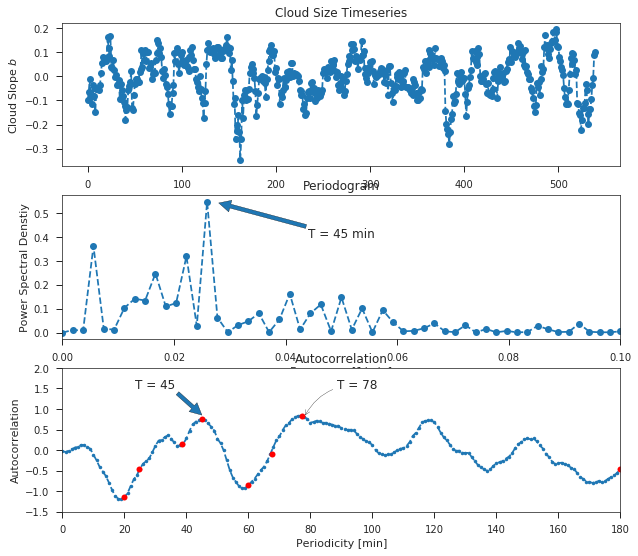

In [6]:
import joblib 

def load_timeseries():
    a_ = joblib.load('../pkl/timeseries.pkl')
    return np.array(a_[0]), np.array(a_[1])

c_, i_ = load_timeseries()

# Advanced detrending 
n_features = 4
gp = lm.BayesianRidge()
gp.fit(np.vander(np.linspace(0, 540, 540), n_features), c_)

y_mean = gp.predict(np.vander(np.linspace(0, 540, 540), n_features))
c_det = c_ - y_mean

X_ = np.arange(540)

#---- Plotting 
fig = plt.figure(1, figsize=(10, 9))
fig.clf()

plt.subplot(3, 1, 1)
plt.title('Cloud Size Timeseries')
plt.ylabel('Cloud Slope $b$')
plt.xlabel('Time [min]')

X = np.linspace(0, 539, 540)

plt.plot(X_, c_det, '--o')
y_mean = c_det

plt.subplot(3, 1, 2)
plt.title('Periodogram')
plt.xlabel('Frequency [1/min]')
plt.ylabel('Power Spectral Denstiy')

xf, yf = signal.periodogram(y_mean)
plt.plot(xf, yf, '--o')

yp = yf[find_nearest(xf, 0.026)]
plt.annotate('T = 45 min', xy=(0.026+0.002, yp-5e-3), xytext=(0.05, 0.4), 
            arrowprops=dict(), ha='center')

plt.xlim([0, 0.1])

candidates = 1/xf[np.argpartition(yf, -8)[-8:]]
print(f'{candidates}')

plt.subplot(3, 1, 3)
plt.title('Autocorrelation')
plt.xlabel('Periodicity [min]')
plt.ylabel('Autocorrelation')

yf = calc_circular_corr(y_mean, y_mean)
xf = np.arange(0, yf.size//2, 1)
yf = yf[yf.size//2:]
plt.plot(xf, yf, '--.')
plt.xlim([0, 180])
for t, item in enumerate(candidates):
    plt.plot(item, yf[find_nearest(xf, item)], 'r.', ms=12)

yp = yf[find_nearest(xf, 45)] + 0.1
plt.annotate('T = 45', xy=(45, yp), xytext=(30, 1.5), ha='center',
            arrowprops=dict())

yp = yf[find_nearest(xf, 78)]
plt.annotate('T = 78', xy=(78, yp), xytext=(95, 1.5), ha='center',
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3, rad=0.3'))

plt.ylim([-1.5, 2])
plt.show()


 In order to study the oscillations in the cloud size distribution, we use our BOMEX dataset to obtain the size distribution at each timestep and apply Gaussian process regression method. The following is a log-log plot of the cloud size distribution at 5 hours into simulation.

In [88]:
def calc_cloud_slope(df, mute=False):
    hist, bin_edges = np.histogram(df['area'], bins=135)

    m_ = (hist > 0)
    x, y = np.log10(bin_edges[1:][m_]), np.log10(hist[m_])

    model = lm.Ridge(fit_intercept=True)
    X = x[:, np.newaxis]
    model.fit(X, y)

    if (mute == False):
        print(f"\t coef_: {model.coef_[0]:.05f}, int_: {model.intercept_:.05f}")

    return model

	 coef_: -1.47449, int_: 4.62274


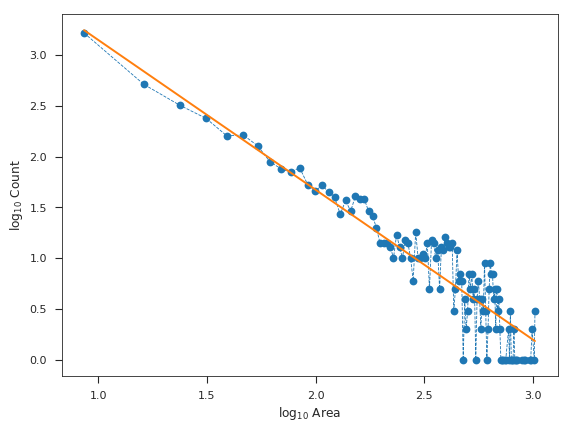

In [98]:
import pyarrow.parquet as pq 

# Use ridge regression method to estimate the 
# slope of the cloud size distribution
df_size = pq.read_table('../pkl/core_dump.pq', nthreads=6).to_pandas()
model = calc_cloud_slope(df_size)

hist, bin_edges = np.histogram(df_size['area'], bins=135)
m_ = (hist > 0)
x, y = np.log10(bin_edges[1:][m_]), np.log10(hist[m_])

#---- Plotting 
fig = plt.figure(1, figsize=(8, 6), dpi=80)
fig.clf()
sns.set_context('notebook')

ax = plt.subplot(1, 1, 1)
plt.xlabel(r'$\log_{10}$ Area')
plt.ylabel(r'$\log_{10}$ Count')

cmap = sns.cubehelix_palette(start=1.2, hue=1, \
                             light=1, rot=-1.05, as_cmap=True)

plt.plot(x, y, '--o', lw=0.75)

y_fit = model.predict(x[:, None])
plt.plot(x, y_fit)
plt.show()

 Since we are working on a log-log plot, we estimated the slope and the intercept of the cloud size distribution, which gives us $b$ (coefficient/slope) and $A$ (intercept) for the power law relationship.
 
 The slope and the intercept is estimated by a ridge regression method.
 
 It has to be noted that due to the nature of the analysis, there is a lot of variance involved in preparing the timeseries dataset. There are uncertainties in measuring the size of the individual cloud, in determining the right bin size to come up with the cloud size distribution, and in estimating the slope (and intercept) of that distribution. As a result, we expect that the observed timeseries will be very noisy. We could test the sensitivity of some parameters (especially the bin size and the weighting function) in the future.
 
 We repeated the regression process for our 9-hour dataset, and plotted the timeseries of the slope $b$ for the cloud size distribution during that period. I have also repeated the following analysis for the intercept $A$, and confirmed that the two variables are highly correlated to each other, but the results for the intercept $A$ is skipped for brevity. We will focus on the oscillatory nature of the slope of the cloud size distribution. 

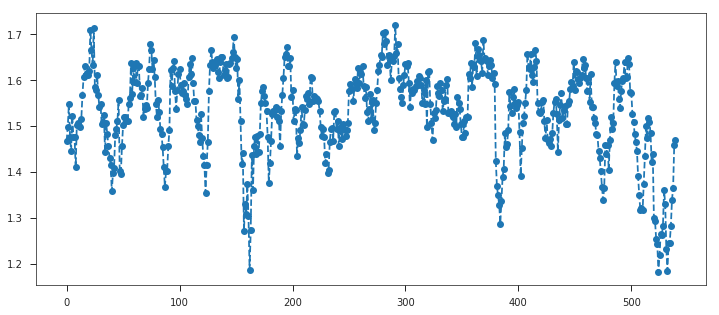

In [23]:
a_ = joblib.load('../pkl/timeseries.pkl')
c_ = a_[0]; i_ = a_[1]
#---- Plotting 
fig = plt.figure(1, figsize=(12, 5))
fig.clf()

plt.plot(np.arange(540), c_, '--o')
plt.show()

 As we can see from the timeseries plot of (the slope of) the cloud size distribution, it is not immediately obvious if the slope of the cloud size distribution has any consistent oscillatory tendencies. Still, that was also the case in the sample wave function in Section 2, so it might be worth trying to use the GP regression method to detect the periodicity in the noisy data.
 
 Like we have already done in Section 2, I have de-trended the timeseries data using the Ridge regression:

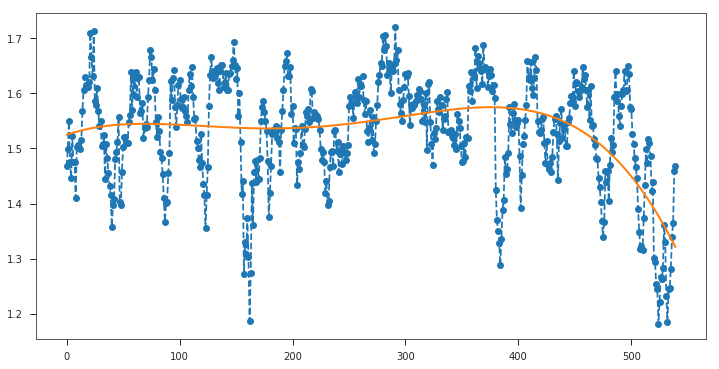

In [24]:
# Advanced detrending 
n_features = 5
gp = lm.BayesianRidge()
gp.fit(np.vander(np.arange(540), n_features), c_)

y_mean = gp.predict(np.vander(np.arange(540), n_features))

#---- Plotting 
fig = plt.figure(1, figsize=(12, 6))
fig.clf()
plt.plot(np.arange(540), c_, '--o')
plt.plot(np.arange(540), y_mean, lw=2)
plt.show()

 The detrended timeseries now looks like:

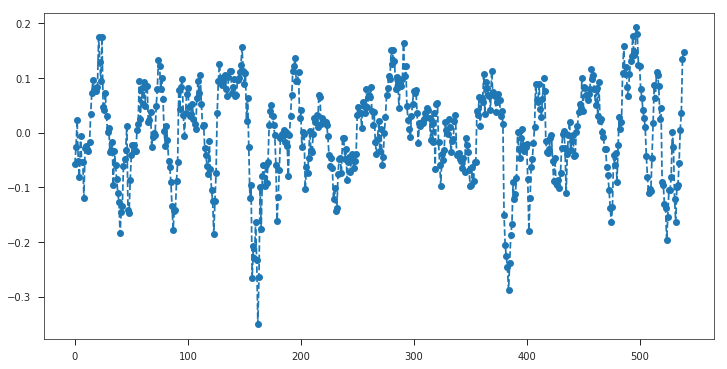

In [25]:
c_det = c_ - y_mean

#---- Plotting 
fig = plt.figure(1, figsize=(12, 6))
fig.clf()

plt.plot(np.arange(540), c_det, '--o')
plt.show()

 Knowing that we have just de-trended the timeseries, I used the *rational quadratic* kernel to account for the local variation, and used two periodic kernels to account for the two periods seen in the Fourier spectral diagram. I have also tested using three for the smallest timescale, most likely corresponding to the eddy turnover timescale at $15$ minutes, but it does not seem to affect the log-marginal likelyhood. So we will ignore it for now.

0.00316**2 * RBF(length_scale=1e+05) + 0.0651**2 * RBF(length_scale=2.94) + 0.165**2 * WhiteKernel(noise_level=0.0271) + 0.0323**2 * ExpSineSquared(length_scale=0.61, periodicity=78) + 0.0376**2 * ExpSineSquared(length_scale=1.05, periodicity=43.5)
953.6128052995028


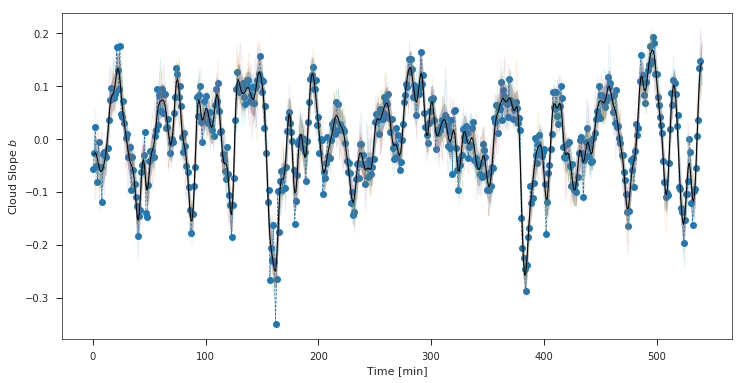

In [34]:
kernel = 1.0 * RBF(length_scale_bounds=(1e3, 1e5)) \
        + 1.0 * RBF() \
        + 1.0 * WhiteKernel(noise_level=1) \
        + 1.0 * ExpSineSquared(length_scale_bounds=(0.1, 10), 
                            periodicity=80, periodicity_bounds=(70, 90)) \
        + 1.0 * ExpSineSquared(length_scale_bounds=(0.1, 10), 
                            periodicity=40, periodicity_bounds=(30, 50))
gp = GaussianProcessRegressor(kernel=kernel,
                              normalize_y=False,
                              n_restarts_optimizer=5)

X_ = np.arange(540)
gp.fit(X_[:, None], np.array(c_det[:540]))

#---- Plotting 
fig = plt.figure(1, figsize=(12, 6))
fig.clf()

ax = plt.subplot(1, 1, 1)
plt.ylabel('Cloud Slope $b$')
plt.xlabel('Time [min]')

plt.plot(np.arange(540), c_det, '--o', lw=0.75)

X = np.linspace(1, 540, 540)
y_mean, y_std = gp.predict(X[:, None], return_std=True)
plt.plot(X, y_mean, 'k', lw=1, zorder=9)
plt.fill_between(X, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)

y_samples = gp.sample_y(X[:, None], 10)
plt.plot(X, y_samples, lw=0.5, alpha=0.2)
plt.show()

 We have added the SE kernel (RBF in *scikit-learn*) as after a few iterations of hyperparameter optimization, it became evident that GP regression was insisting on a long-term trend in the timeseries. This is most likely because the de-trending algorithm isn't aggressive enough. We can probably do better with a custom de-trending function, but for now, simply adding a very smooth, long-term trend to the kernel seems to resolve the issue.
 
 As we can see from the hyperparameters of the posterier distribution, the GP regression method seems to converge towards a periodicity at $77.8$ minutes and another at $43.6$ minutes. We also observe that adding a periodic covariance function to account for the $15$-minute oscillation (according to the eddy turnover timescale) gives a periodicity of $16$ minutes, which is not shown for brevity.
 
 The former periodicity seems to correspond well to the periodicity of roughly $80$ minutes reported in Feingold et al. (2017). However, it is clear that there is another underlying oscillation in our timeseries data at $\approx 45$ minutes, although it is not obvious as to where it is coming from.

 The following figure shows the robustness of the Gaussian Process regression with missing data. We have restructured the above (detrended) dataset such that we have 30 minutes of missing data every hour. Even though the GP does not see the missing data at all, we can see that we end up with an excellent reproduction of the periodicity estimation we have performed above.

In [38]:
kernel = 1.0 * RBF(length_scale_bounds=(1e3, 1e5)) \
        + 1.0 * RBF() \
        + 1.0 * WhiteKernel(noise_level=1) \
        + 1.0 * ExpSineSquared(length_scale_bounds=(0.1, 10), 
                            periodicity=80, periodicity_bounds=(70, 90)) \
        + 1.0 * ExpSineSquared(length_scale_bounds=(0.1, 10), 
                            periodicity=40, periodicity_bounds=(30, 50))
gp = GaussianProcessRegressor(kernel=kernel,
                              normalize_y=False,
                              n_restarts_optimizer=5)

X_ = np.arange(540)
m_ = np.ones_like(X_, dtype=np.bool_)

# 60 minutes of training, followed by 30 minutes of testing
i = 0
while i <= 540:
    i += 60
    m_[i:i+30] = False
    i += 31
gp.fit(np.ma.array(X_[:, None], mask=~m_), np.ma.array(c_det[:540], mask=~m_))
print(gp.kernel_)
print(gp.log_marginal_likelihood_value_)

X = np.linspace(1, 540, 540)
y_mean, y_std = gp.predict(X[:, None], return_std=True)

y_samples = gp.sample_y(X[:, None], 10)

0.00316**2 * RBF(length_scale=1e+05) + 0.0651**2 * RBF(length_scale=2.94) + 0.165**2 * WhiteKernel(noise_level=0.0271) + 0.0323**2 * ExpSineSquared(length_scale=0.61, periodicity=78) + 0.0376**2 * ExpSineSquared(length_scale=1.05, periodicity=43.5)
953.6128052995028


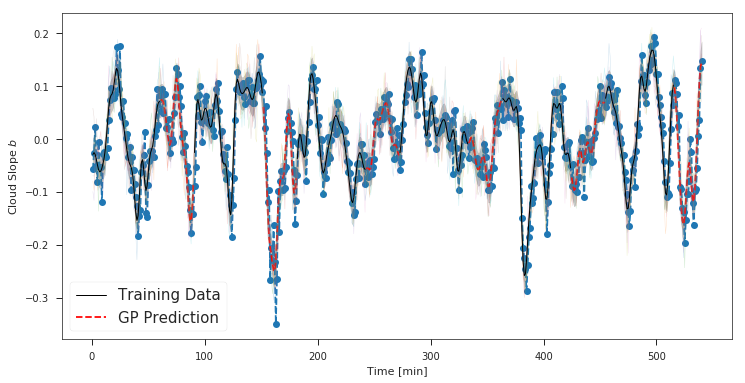

In [42]:
#---- Plotting 
fig = plt.figure(1, figsize=(12, 6))
fig.clf()

ax = plt.subplot(1, 1, 1)
plt.ylabel('Cloud Slope $b$')
plt.xlabel('Time [min]')

t = np.linspace(1, 540, 540)
plt.plot(t, c_det, '--o')
plt.plot(t, np.ma.array(y_mean, mask=~m_), 'k', lw=1, zorder=9, label='Training Data')
i = 0
while i <= 540:
    i += 60
    if i == 60:
        plt.plot(t[i:i+30], y_mean[i:i+30], 'r--', label='GP Prediction')
    else:
        plt.plot(t[i:i+30], y_mean[i:i+30], 'r--')
    i += 31

plt.fill_between(t, y_mean - y_std, y_mean + y_std,
                 alpha=0.2, color='k')
plt.legend(fontsize=15)


plt.plot(X, y_samples, lw=0.5, alpha=0.2)
plt.show()

 At this point we are probably overfitting the noisy timeseries observation. There are ways to avoid this, especially if one wants to make predictions. However, it is not exactly the point of this work.

# 4. References

Blyth, A. M., S. G. Lasher-Trapp, and W. A. Cooper, 2005: A study of thermals in cumulus clouds. *Q. J. R. Meteorol*. Soc, **131**, 1171–1190, doi:10.1256/qj.03.180.

Feingold, G., J. Balsells, F. Glassmeier, T. Yamaguchi, J. Kazil, and A. McComiskey, 2017: Analysis of albedo versus cloud fraction relationships in liquid water clouds using heuristic models and large eddy simulation. *J. Geophys. Res. Atmos*, **122**, 7086–7102, doi:10.1002/2017JD026467.

French, J. R., G. Vali, and R. D. Kelly, 1999: Evolution of small cumulus clouds in Florida: observations of pulsating growth. *Atmos. Res*, **52**, 143–165, doi:10.1016/s0169-8095(99)00024-1.

Grinnell, S. A., C. S. Bretherton, A. M. Fraser, and D. E. Stevens, 1996: Vertical Mass Flux Calculations in Hawaiian Trade Cumulus Clouds from Dual-Doppler Radar. *J. Atmos. Sci*, **53**, 1870–1886, doi:10.1175/1520-0469(1996)053<1870:vmfcih>2.0.co;2.

Heus, T., H. J. J. Jonker, H. E. A. Van den Akker, E. J. Griffith, M. Koutek, and F. H. Post, 2009: A statistical approach to the life cycle analysis of cumulus clouds selected in a virtual reality environment. *J. Geophys. Res*, **114**, 97, doi:10.1029/2008JD010917.

Malkus, J. S., 1952: The slopes of cumulus clouds in relation to external wind shear. *Q. J. R. Meteorol. Soc*, **78**, 530–542, doi:10.1002/qj.49707833804.

Scorer, R. S., and F. H. Ludlam, 1953: Bubble theory of penetrative convection. *Q. J. R. Meteorol. Soc*, **79**, 94–103, doi:10.1002/qj.49707933908.

Zhao, M., and P. H. Austin, 2005a: Life Cycle of Numerically Simulated Shallow Cumulus Clouds. Part I: Transport. *J. Atmos. Sci*, **62**, 1269–1290, doi:10.1175/JAS3414.1.

Zhao, M., and P. H. Austin, 2005b: Life Cycle of Numerically Simulated Shallow Cumulus Clouds. Part II: Mixing Dynamics. *J. Atmos. Sci*, **62**, 1291–1310, doi:10.1175/jas3415.1.